In [ ]:
import os
import sys

#------------------------------------------------------------------------------------
# Here is the setting that enable the GPU in this virtual env. You can ignore it or even comment out if there's no any issue when accessing the GPU.

# 1. Define the correct path to the parent directory of 'nvvm' within your venv
# This path points to the 'cuda_nvcc' folder which contains 'nvvm'
NVVM_ROOT_PATH = "/home/haoyu/114-1_DL_final/.venv/lib/python3.10/site-packages/nvidia/cuda_nvcc/"
XLA_FLAGS="--xla_gpu_cuda_data_dir=/usr/lib/cuda"
# 2. Set the environment variable
os.environ['NVVM_ROOT'] = NVVM_ROOT_PATH
os.environ['XLA_FLAGS'] = XLA_FLAGS

# 3. (Optional but helpful) Set LD_LIBRARY_PATH if it wasn't already set correctly
# This is a general safety measure for WSL setups
if "/usr/lib/wsl/lib" not in os.environ.get('LD_LIBRARY_PATH', ''):
    os.environ['LD_LIBRARY_PATH'] = f"/usr/lib/wsl/lib:{os.environ.get('LD_LIBRARY_PATH', '')}"

print("Environment variables set for CUDA path resolution.")
print(f"Python executable: {sys.executable}")

#------------------------------------------------------------------------------------

path = "/home/haoyu/114-1_DL_final/data/archive/MultiCancer/MultiCancer"
print("資料夾內容:", os.listdir(path))
directory = os.path.join(path, "MultiCancer", "MultiCancer")
# 再次確認最終路徑是否存在
if os.path.exists(directory):
    print(f"成功鎖定資料集路徑: {directory}")
    print("內部檔案:", os.listdir(directory)) # 只列出前5個檔案檢查
else:
    print(f"路徑錯誤，請檢查上面的 '資料夾內容' 來調整 os.path.join")



Environment variables set for CUDA path resolution.
Python executable: /home/haoyu/114-1_DL_final/.venv/bin/python
資料夾內容: ['CervicalCancer', 'ALL', 'Lymphoma', 'OralCancer', 'KidneyCancer', 'BreastCancer', 'LungAndColonCancer', 'BrainCancer']
路徑錯誤，請檢查上面的 '資料夾內容' 來調整 os.path.join


In [2]:
import glob
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
base_path = "/home/haoyu/114-1_DL_final/data/archive/MultiCancer/MultiCancer"


IMG_SIZE = (224, 224)
BATCH_SIZE = 64

def load_data_paths_and_labels(parent_folder, target_classes):
    """
    功能：讀取指定類別的所有圖片路徑與標籤
    回傳：file_paths (圖片路徑列表), labels (對應的數字標籤)
    """
    file_paths = []
    labels = []
    
    # 定義類別對應的數字 (Label Encoding)
    # 例如: {'lung_bnt': 0, 'lung_scc': 1} (依照字母順序)
    class_to_index = {name: i for i, name in enumerate(sorted(target_classes))}
    print(f"類別對應表: {class_to_index}")

    src_dir = os.path.join(base_path, parent_folder)
    
    for class_name in target_classes:
        class_path = os.path.join(src_dir, class_name)
        # 抓取該資料夾下所有 jpg, jpeg, png 圖片
        # 使用 glob 抓取路徑
        image_files = glob.glob(os.path.join(class_path, "*"))
        print(class_path)
        print(f"  - {class_name}: 找到 {len(image_files)} 張圖片")
        
        for img_path in image_files:
            file_paths.append(img_path)
            labels.append(class_to_index[class_name])
            
    return np.array(file_paths), np.array(labels), len(target_classes)

def create_tf_dataset(image_paths, labels, num_classes):
    """
    功能：將路徑列表轉換成 TensorFlow Dataset (取代 image_dataset_from_directory)
    """
    # 1. 建立基礎 Dataset
    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    # 2. 定義讀取圖片的函式
    def load_and_process_image(path, label):
        # 讀取圖片檔案
        img = tf.io.read_file(path)
        # 解碼 (自動偵測格式)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        # 調整大小
        img = tf.image.resize(img, IMG_SIZE)
        # 確保形狀正確
        img.set_shape((IMG_SIZE[0], IMG_SIZE[1], 3))
        
        # 處理標籤 (轉成 One-hot encoding)
        # 如果是二元分類也可以不轉，但為了跟之前一致，這裡轉成 One-hot
        label = tf.one_hot(label, depth=num_classes)
        
        return img, label

    # 3. 套用轉換並設定 Batch
    ds = ds.map(load_and_process_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(buffer_size=1000) # 打亂資料
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE) # 加速讀取
    
    return ds

# ==========================================
# 主流程執行
# ==========================================

target_classes = ['lung_scc', 'lung_bnt']
#target_classes = ['lung_aca','lung_scc', 'lung_bnt']
parent_folder = "LungAndColonCancer"

# 1. 收集所有路徑與標籤
print("--- 1. 收集檔案路徑 ---")
X, y, num_classes = load_data_paths_and_labels(parent_folder, target_classes)

# 2. 使用 train_test_split 切割
# 這裡切兩刀，達到 70% / 15% / 15% 的比例
print("\n--- 2. 使用 train_test_split 切割資料 ---")

# 第一刀：切出 80% Training，剩下 30% 給 Temp
# stratify=y 代表依照類別比例去切，保證每一份都有 scc 和 bnt
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y
)

# 第二刀：把剩下的 Temp (30%) 對半切，變成 15% Val 和 15% Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=123, stratify=y_temp
)

print(f"分割結果:")
print(f"  Training Set:   {len(X_train)} 張 (70%)")
print(f"  Validation Set: {len(X_val)} 張 (15%)")
print(f"  Test Set:       {len(X_test)} 張 (15%)")

# 3. 轉換回 TensorFlow Dataset 格式 (讓模型可以吃)
print("\n--- 3. 建立 TensorFlow Datasets ---")
train_ds = create_tf_dataset(X_train, y_train, num_classes)
val_ds   = create_tf_dataset(X_val, y_val, num_classes)
test_ds  = create_tf_dataset(X_test, y_test, num_classes)

print("完成！現在您可以直接將 train_ds 丟入 model.fit() 了。")

2025-12-07 14:16:30.620348: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-07 14:16:30.649088: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-07 14:16:31.628705: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


--- 1. 收集檔案路徑 ---
類別對應表: {'lung_bnt': 0, 'lung_scc': 1}
/home/haoyu/114-1_DL_final/data/archive/MultiCancer/MultiCancer/LungAndColonCancer/lung_scc
  - lung_scc: 找到 5000 張圖片
/home/haoyu/114-1_DL_final/data/archive/MultiCancer/MultiCancer/LungAndColonCancer/lung_bnt
  - lung_bnt: 找到 5000 張圖片

--- 2. 使用 train_test_split 切割資料 ---
分割結果:
  Training Set:   7000 張 (70%)
  Validation Set: 1500 張 (15%)
  Test Set:       1500 張 (15%)

--- 3. 建立 TensorFlow Datasets ---


I0000 00:00:1765088192.614698  323293 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


完成！現在您可以直接將 train_ds 丟入 model.fit() 了。


正在從 train_ds 抓取一批圖片...


2025-12-07 14:16:33.302281: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


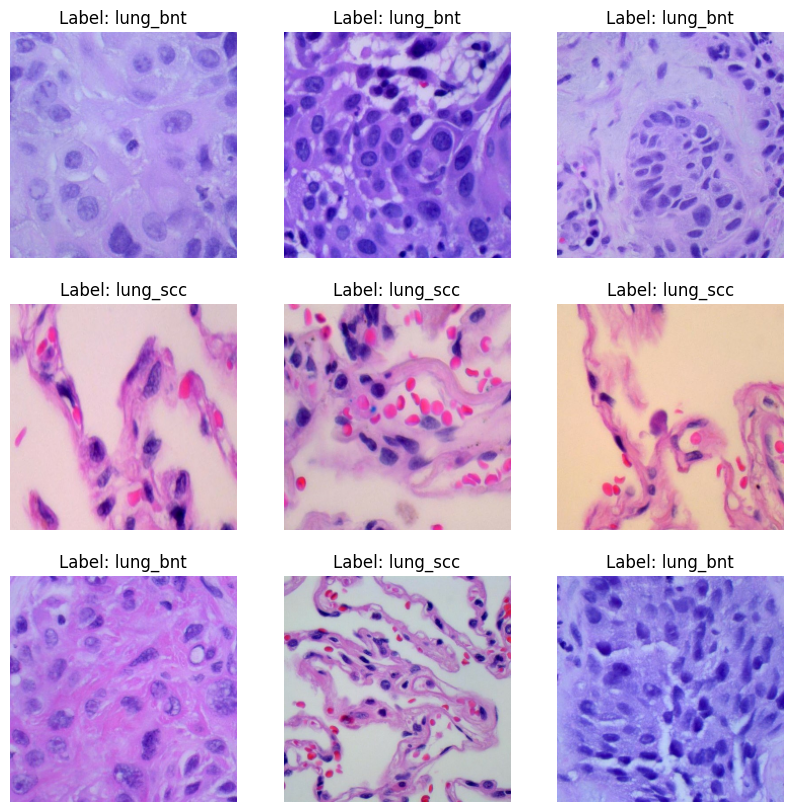

In [3]:
import matplotlib.pyplot as plt

# 1. 定義類別名稱 (必須依照您之前 sorted() 的順序)
# 根據上一段程式碼的邏輯，順序是依照字母排列的
class_names = ['lung_scc', 'lung_bnt'] 
#class_names = ['lung_aca','lung_scc', 'lung_bnt'] 


print("正在從 train_ds 抓取一批圖片...")

# 2. 從資料集中取出一個 Batch (take(1))
# images 的形狀會是 (32, 224, 224, 3)
# labels 的形狀會是 (32, 2) <- 因為是 One-hot
for images, labels in train_ds.take(1):
    
    # 設定畫布大小 (例如 3x3 的九宮格)
    plt.figure(figsize=(10, 10))
    
    # 只顯示前 9 張圖
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        # 顯示圖片
        # 注意：tf.image.resize 會把圖片轉成 float 格式，
        # 所以我們要轉回 uint8 (0-255) 才能讓 matplotlib 正確顯示顏色
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # 解析標籤
        # 因為 label 是 One-hot (如 [0, 1])，我們要用 argmax 找出是第幾個位置為 1
        label_index = np.argmax(labels[i].numpy())
        label_name = class_names[label_index]
        
        plt.title(f"Label: {label_name}")
        plt.axis("off") # 關閉座標軸看起來比較乾淨

plt.show()

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras import mixed_precision

# Set the global policy to 'mixed_float16'
# This automatically casts most layers to float16, while keeping key ops (like loss) in float32.
mixed_precision.set_global_policy('mixed_float16')

# 設定參數
INPUT_SHAPE = (224, 224, 3) # 注意：Xception 官方預設通常是 299x299，但 224x224 也可以跑
NUM_CLASSES = 2 
EPOCHS = 10      

# 定義一個「模型工廠」函式
def build_model(model_name):
    print(f"正在建構模型: {model_name} ...")
    
    # 1. 定義輸入層 (這裡接收 0-255 的原始圖片)
    inputs = tf.keras.Input(shape=INPUT_SHAPE)
    
    # 2. 根據模型名稱選擇正確的預處理與 Base Model
    if model_name == 'ResNet50':
        # ResNet 需要 Caffe 風格的預處理 (轉 BGR, 減 Mean)
        x = tf.keras.applications.resnet50.preprocess_input(inputs)
        base_model = tf.keras.applications.ResNet50(
            include_top=False, weights='imagenet', input_tensor=x
        )
        
    elif model_name == 'DenseNet121':
        # DenseNet 需要 Scale 到 0-1 並正規化
        x = tf.keras.applications.densenet.preprocess_input(inputs)
        base_model = tf.keras.applications.DenseNet121(
            include_top=False, weights='imagenet', input_tensor=x
        )
    
    # ==========================================
    # [新增] Xception: Depthwise Separable Conv 的代表
    # ==========================================
    elif model_name == 'Xception':
        # Xception 的預處理是將像素值縮放到 -1 到 1 之間
        x = tf.keras.applications.xception.preprocess_input(inputs)
        base_model = tf.keras.applications.Xception(
            include_top=False, weights='imagenet', input_tensor=x
        )
        
    elif model_name == 'EfficientNetB0':
        # EfficientNet 內建 Rescaling，直接吃 0-255
        base_model = tf.keras.applications.EfficientNetB0(
            include_top=False, weights='imagenet', input_tensor=inputs
        )
        
    elif model_name == 'MobileNetV3Small':
        # MobileNetV3 內建 Rescaling，直接吃 0-255
        base_model = tf.keras.applications.MobileNetV3Small(
            include_top=False, weights='imagenet', input_tensor=inputs
        )
    else:
        raise ValueError("未知的模型名稱")

    # 3. 凍結 Base Model (Transfer Learning 標準起手式)
    base_model.trainable = False 

    # 4. 加上分類頭 (Classification Head)
    x = base_model.output
    x = layers.Dropout(0.3)(x)
    x = layers.GlobalAveragePooling2D()(x) # 把特徵圖壓扁
    x = layers.BatchNormalization()(x)     # 加速收斂
    x = layers.Dropout(0.2)(x)             # 防止過擬合
    
    # 輸出層
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    # 5. 組合模型
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    
    # 6. 編譯模型
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# ==========================================
# 主訓練迴圈
# ==========================================

# 您想要訓練的模型清單 (已加入 Xception)
models_to_train = [
    'ResNet50', 
    'DenseNet121', 
    'Xception',       # <--- 新增在這裡
    'EfficientNetB0', 
    'MobileNetV3Small'
]

# 用來存儲每個模型的訓練歷史
history_dict = {}

for name in models_to_train:
    print("\n" + "="*40)
    print(f"開始訓練 {name}")
    print("="*40)
    
    # 1. 建立模型
    model = build_model(name)
    
    # 2. 設定 Early Stopping
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True, verbose=1
    )
    
    # 3. 開始訓練
    # 請確保 train_ds 與 val_ds 已經在您的環境中定義好
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[early_stop],
        verbose=1
    )
    
    # 4. 存檔與記錄
    history_dict[name] = history.history
    model.save(f"{name}_lung_scc_classifier.h5")
    print(f"模型 {name} 已儲存。")
    
    # 5. (可選) 在測試集上評估一次
    if 'test_ds' in locals():
        print(f"正在 Test Set 上評估 {name}...")
        test_loss, test_acc = model.evaluate(test_ds)
        print(f"{name} Test Accuracy: {test_acc:.4f}")

    # 清除記憶體，避免 GPU 爆掉
    tf.keras.backend.clear_session()


開始訓練 ResNet50
正在建構模型: ResNet50 ...
Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.9870 - loss: 0.0297 - val_accuracy: 1.0000 - val_loss: 0.0052
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 8.2692e-04
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9999 - loss: 7.0417e-04 - val_accuracy: 1.0000 - val_loss: 3.1619e-04
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 1.0000 - loss: 4.1750e-04 - val_accuracy: 1.0000 - val_loss: 1.3795e-04
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 1.0000 - loss: 3.2620e-04 - val_accuracy: 1.0000 - val_loss: 8.5126e-05
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 1.0000 - loss: 2.1611e-04 - val_accuracy: 1.0000 - val_loss: 6.5274e-05
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 1.0000 - loss: 2.9548e-04 - val_accuracy: 1.0000 - val_loss: 4.5058e-05
Epoch 8/10
110/1

模型 ResNet50 已儲存。
正在 Test Set 上評估 ResNet50...
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 2.9045e-05
ResNet50 Test Accuracy: 1.0000

開始訓練 DenseNet121
正在建構模型: DenseNet121 ...
Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 150ms/step - accuracy: 0.9613 - loss: 0.0890 - val_accuracy: 0.9987 - val_loss: 0.0300
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9994 - loss: 0.0054 - val_accuracy: 1.0000 - val_loss: 0.0095
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9997 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9996 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9999 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 8.6843e-04
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 1.0000 - loss: 9.5714e-04 - val_accuracy: 1.0000 - val_loss: 5.1947e-04
Epoch 7/10
110/1

模型 DenseNet121 已儲存。
正在 Test Set 上評估 DenseNet121...
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - loss: 1.0849e-04
DenseNet121 Test Accuracy: 1.0000

開始訓練 Xception
正在建構模型: Xception ...
Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.9901 - loss: 0.0245 - val_accuracy: 0.9993 - val_loss: 0.0204
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9994 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 6.3743e-04
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9997 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 2.1341e-04
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9996 - loss: 9.9858e-04 - val_accuracy: 1.0000 - val_loss: 1.2179e-04
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 1.0000 - loss: 4.0003e-04 - val_accuracy: 1.0000 - val_loss: 6.1123e-05
E

模型 Xception 已儲存。
正在 Test Set 上評估 Xception...
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 1.0000 - loss: 5.7605e-05
Xception Test Accuracy: 1.0000

開始訓練 EfficientNetB0
正在建構模型: EfficientNetB0 ...
Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 0.9829 - loss: 0.0389 - val_accuracy: 1.0000 - val_loss: 0.0213
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9990 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9994 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 7.0747e-04
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9994 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 2.0135e-04
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9994 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 7.9717e-05
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 1.0000 - loss: 6.2100e-04 - val_accuracy: 1.0000 - val_loss: 4.3666e-05
Ep

模型 EfficientNetB0 已儲存。
正在 Test Set 上評估 EfficientNetB0...
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.5738e-05
EfficientNetB0 Test Accuracy: 1.0000

開始訓練 MobileNetV3Small
正在建構模型: MobileNetV3Small ...
Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9579 - loss: 0.1007 - val_accuracy: 1.0000 - val_loss: 0.0235
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9984 - loss: 0.0087 - val_accuracy: 1.0000 - val_loss: 0.0062
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9993 - loss: 0.0049 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9991 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9997 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 5.9600e-04
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 3.99

模型 MobileNetV3Small 已儲存。
正在 Test Set 上評估 MobileNetV3Small...
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 1.0007e-04
MobileNetV3Small Test Accuracy: 1.0000


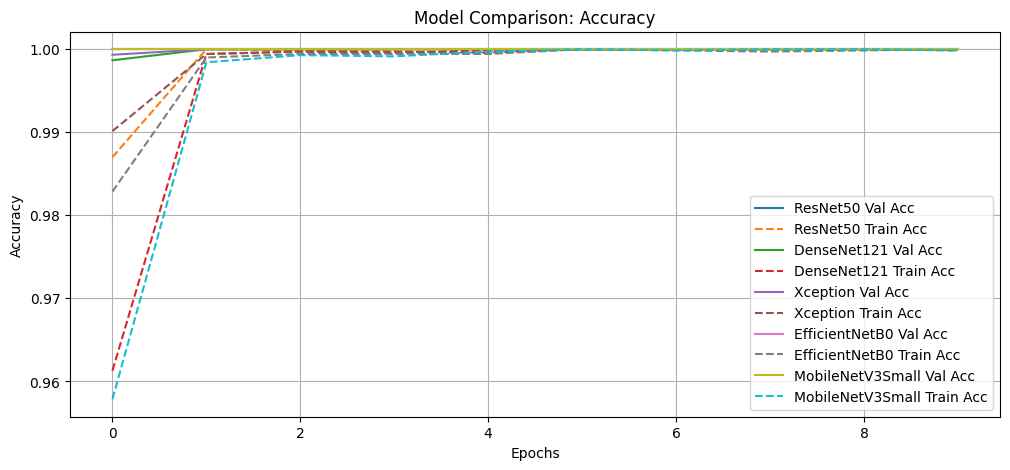

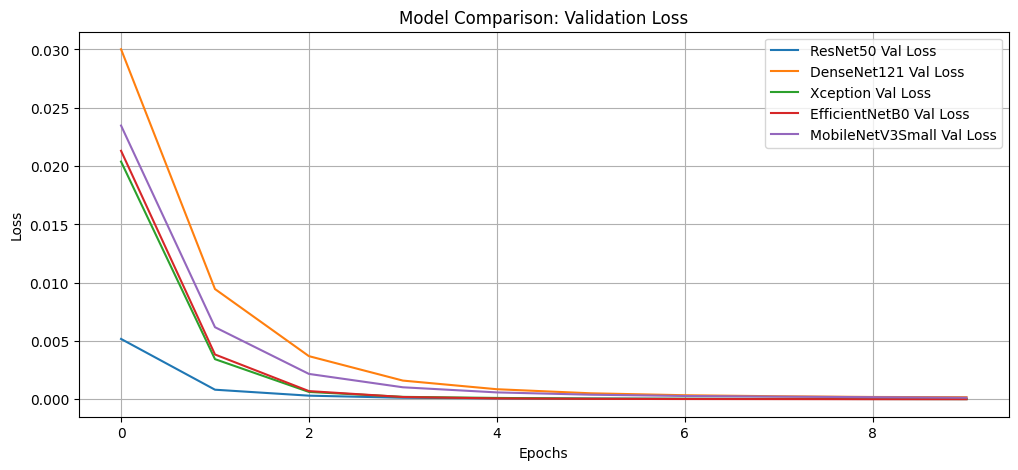

In [9]:
# 畫圖比較各模型的 Accuracy
plt.figure(figsize=(12, 5))

for name, history in history_dict.items():
    plt.plot(history['val_accuracy'], label=f"{name} Val Acc", linestyle='-')
    plt.plot(history['accuracy'], label=f"{name} Train Acc", linestyle='--')

plt.title('Model Comparison: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 畫圖比較各模型的 Loss
plt.figure(figsize=(12, 5))

for name, history in history_dict.items():
    plt.plot(history['val_loss'], label=f"{name} Val Loss")

plt.title('Model Comparison: Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# ==========================================
# 0. 強制重新定義 Dataset (防呆機制)
# ==========================================
def create_eval_dataset_safe(image_paths, labels, num_classes_dataset):
    # 確保這裡絕對沒有 shuffle
    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    def load_and_process_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, IMG_SIZE)
        img.set_shape((IMG_SIZE[0], IMG_SIZE[1], 3))
        # Oral 只有 2 類，所以 depth=2
        label = tf.one_hot(label, depth=num_classes_dataset)
        return img, label
    
    ds = ds.map(load_and_process_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

print("🔄 強制重新載入 Oral Dataset (確保無 Shuffle)...")

# 重新讀取路徑 (確保變數存在)
oral_target_classes = ['oral_normal', 'oral_scc']
X_oral, y_oral, _ = load_data_paths_and_labels("OralCancer", oral_target_classes)

# 重新建立變數
oral_ds_eval = create_eval_dataset_safe(X_oral, y_oral, num_classes_dataset=2)

print("✅ Oral Dataset 準備完成，現在可以安全地跑評估了！")

🔄 強制重新載入 Oral Dataset (確保無 Shuffle)...
類別對應表: {'oral_normal': 0, 'oral_scc': 1}
/home/haoyu/114-1_DL_final/data/archive/MultiCancer/MultiCancer/OralCancer/oral_normal
  - oral_normal: 找到 5001 張圖片
/home/haoyu/114-1_DL_final/data/archive/MultiCancer/MultiCancer/OralCancer/oral_scc
  - oral_scc: 找到 5001 張圖片
✅ Oral Dataset 準備完成，現在可以安全地跑評估了！



############################################################
🔥 正在評估模型: ResNet50 🔥
############################################################
正在建構模型: ResNet50 ...
正在進行預測...
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step

[ResNet50] 跨領域二元分類報告 (SCC vs Non-SCC):
                  precision    recall  f1-score   support

Normal (Non-SCC)       0.49      0.20      0.28      5001
             SCC       0.50      0.79      0.61      5001

        accuracy                           0.49     10002
       macro avg       0.49      0.49      0.45     10002
    weighted avg       0.49      0.49      0.45     10002

🏆 F1-Score (SCC class): 0.6095


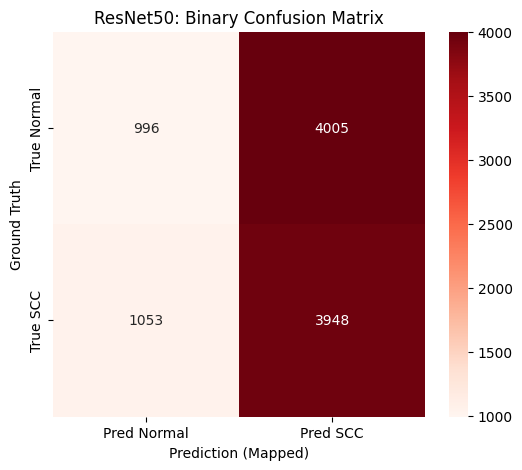


############################################################
🔥 正在評估模型: DenseNet121 🔥
############################################################
正在建構模型: DenseNet121 ...
正在進行預測...
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step

[DenseNet121] 跨領域二元分類報告 (SCC vs Non-SCC):
                  precision    recall  f1-score   support

Normal (Non-SCC)       0.58      0.07      0.13      5001
             SCC       0.51      0.95      0.66      5001

        accuracy                           0.51     10002
       macro avg       0.54      0.51      0.39     10002
    weighted avg       0.54      0.51      0.39     10002

🏆 F1-Score (SCC class): 0.6593


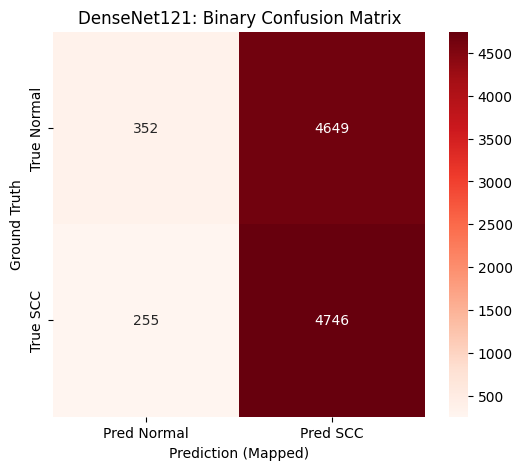


############################################################
🔥 正在評估模型: EfficientNetB0 🔥
############################################################


正在進行預測...
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step

[EfficientNetB0] 跨領域二元分類報告 (SCC vs Non-SCC):
                  precision    recall  f1-score   support

Normal (Non-SCC)       0.49      0.42      0.45      5001
             SCC       0.49      0.56      0.53      5001

        accuracy                           0.49     10002
       macro avg       0.49      0.49      0.49     10002
    weighted avg       0.49      0.49      0.49     10002

🏆 F1-Score (SCC class): 0.5251


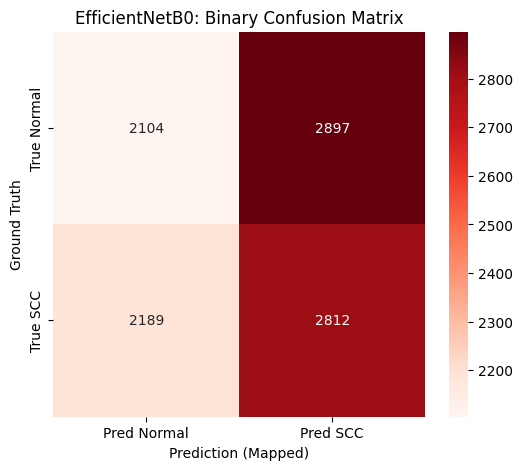


############################################################
🔥 正在評估模型: MobileNetV3Small 🔥
############################################################
正在建構模型: MobileNetV3Small ...
正在進行預測...
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step

[MobileNetV3Small] 跨領域二元分類報告 (SCC vs Non-SCC):
                  precision    recall  f1-score   support

Normal (Non-SCC)       0.58      0.05      0.09      5001
             SCC       0.50      0.96      0.66      5001

        accuracy                           0.51     10002
       macro avg       0.54      0.51      0.38     10002
    weighted avg       0.54      0.51      0.38     10002

🏆 F1-Score (SCC class): 0.6615


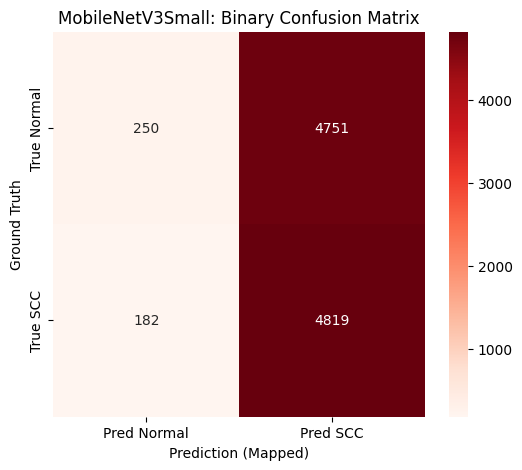

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# ==========================================
# 0. 基礎設定
# ==========================================
#NUM_CLASSES = 2
IMG_SIZE = (224, 224)
#BATCH_SIZE = 32

# (假設 Dataset 建立函式與上面相同，省略不重複貼)
# 請確保 oral_ds_eval 已經準備好且沒有 shuffle

# ==========================================
# 1. 迴圈評估所有模型
# ==========================================
target_models = ['ResNet50', 'DenseNet121', 'EfficientNetB0', 'MobileNetV3Small']
# 用來顯示報表的標籤名稱
binary_class_names = ['Normal (Non-SCC)', 'SCC']

for model_name in target_models:
    print("\n" + "#"*60)
    print(f"🔥 正在評估模型: {model_name} 🔥")
    print("#"*60)
    
    model_filename = f"{model_name}_lung_scc_classifier.h5"
    
    # --- A. 載入模型 ---
    try:
        model = tf.keras.models.load_model(model_filename)
    except:
        # 如果直接載入失敗，改用重建模式
        try:
            model = build_model(model_name)
            model.load_weights(model_filename)
        except Exception as e:
            print("無法載入模型，跳過")
            print(e)
            continue


    # --- B. 模型預測 ---
    print("正在進行預測...")
    y_pred_probs = model.predict(oral_ds_eval, verbose=1)
    y_pred_raw = np.argmax(y_pred_probs, axis=1) # 原始預測: 0, 1, 2

    # --- C. 關鍵步驟：將 3 類別轉為 2 類別 (Binary Mapping) ---
    # 邏輯：只要預測是 Lung SCC (Index 2)，就當作 1；其他的 (ACA/Benign) 都當作 0
    #y_pred_binary = np.where(y_pred_raw == 2, 1, 0)
    y_pred_binary = y_pred_raw
    
    # y_true 已經是 0(Normal) 和 1(SCC) 了，不需要動

    # --- D. 計算完整指標 (Precision, Recall, F1) ---
    y_true_eval = y_oral
    print(f"\n[{model_name}] 跨領域二元分類報告 (SCC vs Non-SCC):")
    
    #這會直接幫您算出 F1-score, Precision, Recall, Support
    report = classification_report(y_oral, y_pred_binary, target_names=binary_class_names)
    
    print(report)
    
    # 額外單獨印出 F1 分數
    f1 = f1_score(y_oral, y_pred_binary)
    print(f"🏆 F1-Score (SCC class): {f1:.4f}")

    # --- E. 混淆矩陣 (2x2) ---
    cm = confusion_matrix(y_oral, y_pred_binary)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
                xticklabels=['Pred Normal', 'Pred SCC'], 
                yticklabels=['True Normal', 'True SCC'])
    plt.title(f'{model_name}: Binary Confusion Matrix')
    plt.xlabel('Prediction (Mapped)')
    plt.ylabel('Ground Truth')
    plt.show()

    tf.keras.backend.clear_session()